In [1]:
from acevedo_clss_and_fcns import * 
from sklearn.metrics import roc_curve, auc

device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")

from graph_tool import *
from graph_tool.draw import * 
import matplotlib
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def get_nx_G_and_export_graphml(edge_weights, graphml_path: str =  "./results/graphs/tmp.graphml"):
    
    edge_list = []
    for i, r in edge_weights[["node1","node2"]].iterrows():
        edge_list.append((r[0],r[1]))        
    G = nx.Graph()
    G.add_edges_from(edge_list)  
    scaler = MinMaxScaler(feature_range=(1, 5))
    weights = list(scaler.fit_transform(
        np.array(edge_weights.select_dtypes(include=np.number).sum(axis=1)).reshape(-1, 1)).squeeze()
    )
    w  = dict(zip(G.edges() , weights))
    nx.set_edge_attributes(G, w, "weights")
    nx.write_graphml(G, graphml_path)
    return copy.deepcopy(G)

def export_visualization( vertex_size:int=3, graphml_path:str= "./results/graphs/tmp.graphml"
                          ):
    
    GT    = load_graph(graphml_path)
    pos = sfdp_layout(GT,  C=1,p=2,  theta= 1.005, r = 9, K = 3)
    graph_draw(GT, pos = pos, #bg_color = 'white', 
            output = "./results/figures/temp.png",
            edge_pen_width = GT._Graph__edge_properties.weights, 
            edge_color= "navy",#GT._Graph__edge_properties.weights, 
            vertex_size= vertex_size,
            adjust_aspect = True, fit_view_ink = True,
            vcmap= (matplotlib.cm.PuBu, 1  ),
            ecmap= (matplotlib.cm.Blues, .8), elen = 5, output_size = (500, 500))
    
    
    graph_masked = matplotlib.image.imread("./results/figures/temp.png")
    os.remove("./results/figures/temp.png")
    os.remove(graphml_path)
    return graph_masked
    


def get_degree_sequence(G):
    

    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    #dmax = max(degree_sequence)
    #fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    #axgrid = fig.add_gridspec(5, 4)
    #degree_counts = np.unique(degree_sequence, return_counts=True)
    return(degree_sequence)
def place_image(im, ax=None, zoom=1, letter='', Density=np.nan, Modularity=np.nan, table_pos = ''):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom)
    ab       = AnchoredOffsetbox(loc='center', child=imagebox, pad=0, borderpad =0, frameon=False)
    ax.add_artist(ab)
    ax.set_title(letter, fontsize = 12,  fontweight ="bold", loc='left')

    row_labels=['Density','Modularity']
    table_vals=[[np.round(Density,5)], [np.round(Modularity,5)]]
# the rectangle is where I want to place the table
    the_table = ax.table(cellText=table_vals,
                  colWidths = [.5,1], 
                  rowLabels=row_labels,
                  
                  #colLabels=col_labels,
                  loc=table_pos)
    the_table.auto_set_font_size(True)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.axis('off')



def make_graph_plot(graph_masked, masked_density, masked_modularity, NX_masked, MASKED_Concentration, export_path):
    plt.style.use('ggplot')   

    fig = plt.figure(figsize=(21,3))
    ax0 = plt.subplot2grid((2, 8), (0, 0), rowspan=2 , colspan=2)
    ax1 = plt.subplot2grid((2, 8), (0, 2), rowspan=1 ,colspan=2)
    ax2 = plt.subplot2grid((2, 8), (1, 2), rowspan=1 ,colspan=2)

    plt.subplots_adjust(left=0.1, bottom=0.01, right=.7, top=1, wspace=.7, hspace=.5)    
        

    place_image(graph_masked,letter = '', ax=ax0,zoom=0.2,Density=masked_density, Modularity=masked_modularity, table_pos = 'bottom')

    ax1.hist(get_degree_sequence(NX_masked), bins=80, color='brown')
    ax1.set_yscale('log')
    ax1.set_title('', fontsize = 12,  fontweight ="bold", loc='left')
    ax1.set_xlabel('Degree',fontsize = 11)
    ax1.set_ylabel('Nodes',fontsize = 11)


    ax2.hist(MASKED_Concentration.all_edge_scores, bins=200, color='navy')
    #ax2.set_yscale('log')
    ax2.set_title('', fontsize = 12,  fontweight ="bold", loc='left')
    ax2.set_xlabel('Score',fontsize = 11)
    ax2.set_ylabel('Edges',fontsize = 11)
    plt.savefig(export_path,
            bbox_inches ="tight",
            pad_inches = 0.01,
            transparent = False, dpi=200)
    plt.show()
    
import networkx.algorithms.community as nx_comm
import matplotlib



def get_nx_and_visualization(df,vertex_size=3):
    NX_masked             = get_nx_G_and_export_graphml(df)    
    graph_masked          = export_visualization(vertex_size, graphml_path= "./results/graphs/tmp.graphml")
    return(NX_masked, graph_masked)
    
def make_graph_and_distributions(df, vertex_size,saving_path):

    NX_masked, graph_masked = get_nx_and_visualization(df, vertex_size)
    masked_modularity     = nx_comm.modularity(NX_masked, nx_comm.label_propagation_communities(NX_masked)) 
    masked_density        = nx.density(NX_masked)
    make_graph_plot(graph_masked, masked_density, masked_modularity, NX_masked, df, 
                   saving_path)

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


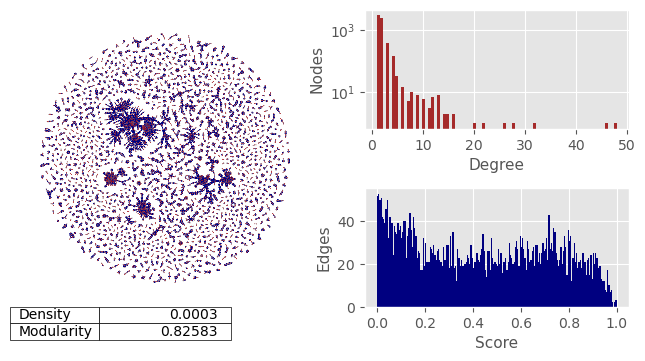

In [17]:

MASKED_FLUX  = pd.read_csv("./results/explanations/to_GraphTools_visualization_explanatory_subgraph_MASKED_GIN_FLUX.csv").drop("genes", axis=1, inplace=False)
make_graph_and_distributions(MASKED_FLUX, vertex_size=2, saving_path= "./results/figures/Figure_3_subplot_FLUX.png")








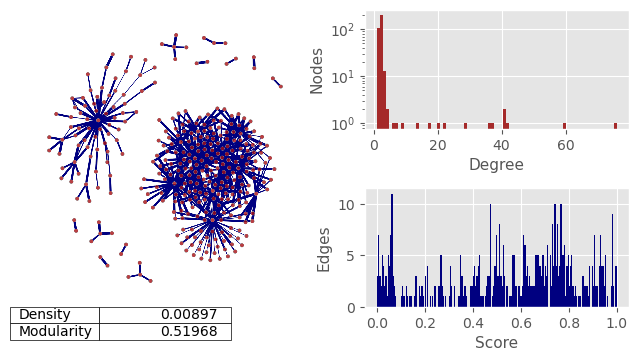

In [16]:
MASKED_Concentration  = pd.read_csv("./results/explanations/to_GraphTools_visualization_explanatory_subgraph_MASKED_GIN_Concentration.csv").drop("genes", axis=1, inplace=False)





make_graph_and_distributions(MASKED_Concentration, vertex_size=7,saving_path= "./results/figures/Figure_3_subplot_Concentration.png")

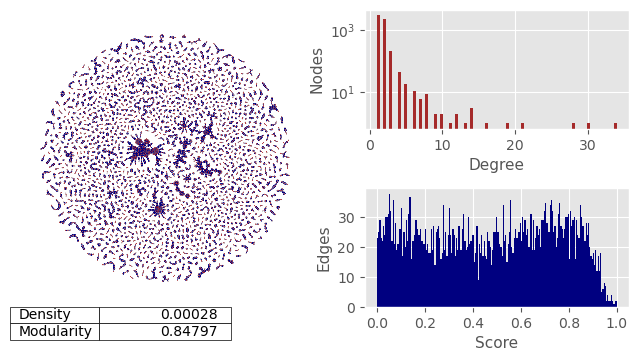

In [19]:
MASKED_Concen_plus_Fluxes  = pd.read_csv("./results/explanations/to_GraphTools_visualization_explanatory_subgraph_MASKED_GIN_Concen_plus_Fluxes.csv").drop("genes", axis=1, inplace=False)

make_graph_and_distributions(MASKED_Concen_plus_Fluxes,vertex_size=2 ,saving_path = "./results/figures/Figure_3_subplot_Concen_plus_Fluxes.png")